# Ninjacart Business Case:

## Business Problem:
- Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

- As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

## Dataset:

### Context:

- This dataset contains images of the following food items: noise-Indian market and images of vegetables- onion, potato and tomato.

### Data Collection:

- The images in this dataset were scraped from Google.

#### Content:

- This dataset contains a folder train, which has a total of 3135 images, split into four folders as follows:

  - Tomato : 789
  - Potato : 898
  - Onion : 849
  - Indian market : 599

- This dataset contains another folder test which has a total of 351 images, split into four folders

  - Tomato : 106
  - potato : 83
  - onion : 81
  - Indian market : 81

#### Inspiration:

- The objective is to develop a program that can recognize the vegetable item(s) in a photo and identify them for the user.

### Importing required Libraries and Dataset:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import random
import shutil

from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import MobileNetV3Large

# For Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
!python -m wget https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view


Saved under view


### Dividing Train Data into Train and Validation:

In [10]:
test_size = 0.2
classes = os.listdir("ninjacart_data/train")
os.mkdir("ninjacart_data/val")
for cls in classes:
    os.mkdir(f"ninjacart_data/val/{cls}")
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    val_files = random.sample(file_paths, k=int(len(file_paths)*test_size))
    for img in val_files:
        shutil.move(img, f'ninjacart_data/val/{cls}/')

### Exploratory Data Analysis (EDA):

#### Plotting images from dataset randomly:


In [11]:
class_dirs = os.listdir("ninjacart_data/train") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

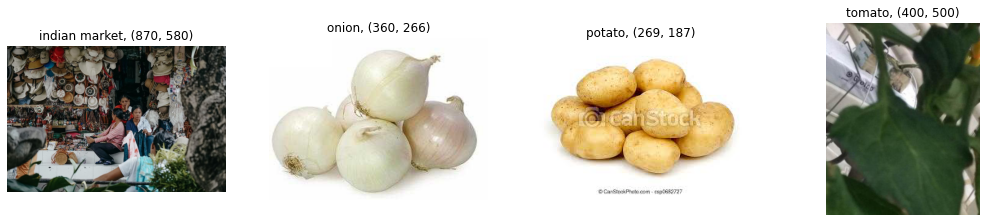

In [13]:
## Visualize Random Sample from each class

plt.figure(figsize=(18, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
            class  count
0  indian market    480
1          onion    680
2         potato    719
3         tomato    632


<AxesSubplot:title={'center':'Training Data Count per class'}, xlabel='class'>

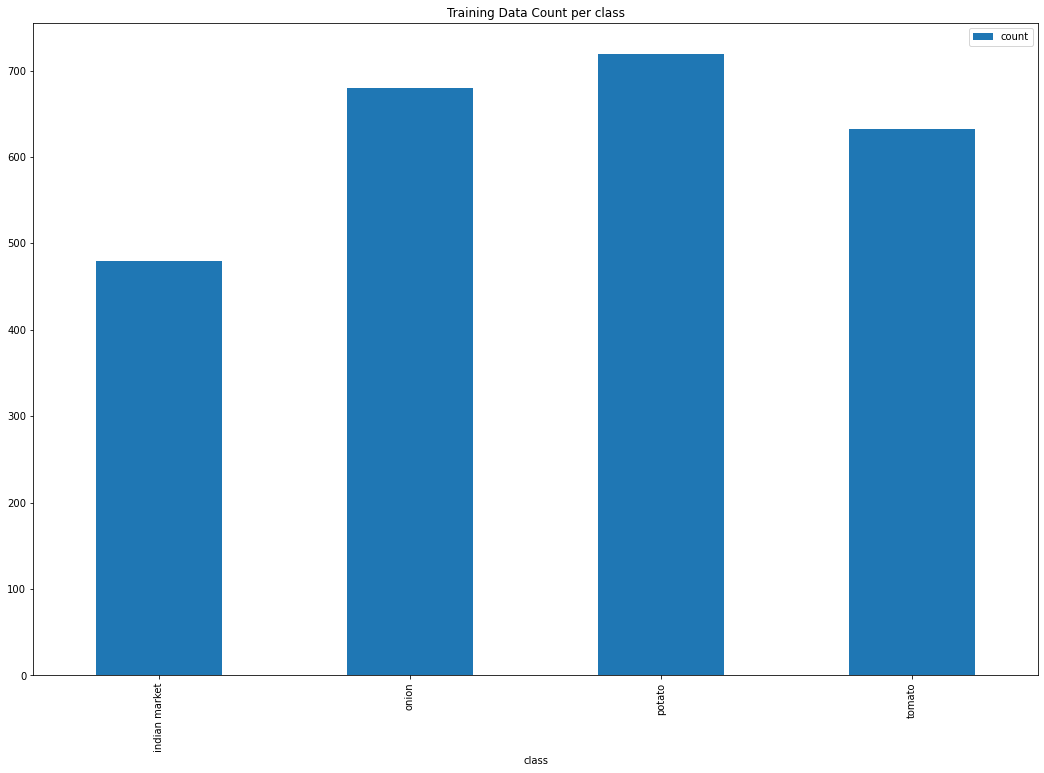

In [17]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(), # keys of count_dict are class labels
    "count": count_dict.values(), # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

plt.rcParams["figure.figsize"] = (18,12)
# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")

### Data Modellig:

#### Loading data into Keras dataset:

In [18]:
def load_data(base_dir="ninjacart_data"):
    # checking if the data folders are present
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/val") and os.path.exists(f"{base_dir}/test")
    
    print('\nLoading Data...')
    train_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/train", shuffle=True, label_mode='categorical')
    
    val_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/val", shuffle=False, label_mode='categorical')
    
    test_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/test", shuffle=False, label_mode='categorical')
    
    return train_data, val_data, test_data, train_data.class_names

In [19]:
train_data, val_data, test_data, class_names = load_data()


Loading Data...
Found 2511 files belonging to 4 classes.
Found 624 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


#### Making all images of Uniform Dimensions and Rescaling:

In [20]:
def preprocess(train_data, val_data, test_data, target_height=224, target_width=224):
    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = tf.keras.Sequential(
        name="data_preprocess",
        layers=[
            tf.keras.layers.Resizing(target_height, target_width),
            tf.keras.layers.Rescaling(1.0/255),
        ]
    )
    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

### Model Building:

#### Baseline Model (Defining the CNN Classifier model from scratch):

In [22]:
def baseline(height=224, width=224):
    num_classes = 4
    hidden_size = 256
    
    model = tf.keras.Sequential(
        name="model_cnn",
        layers=[
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=hidden_size, activation='relu'),
            tf.keras.layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [23]:
model = baseline()
model.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 256)               51380480  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 51,381,956
Trainable params: 51,381,956
Non-trainable params: 0
_____________________________________________

#### Compile and Train:

In [27]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="./tmp/checkpoint"):
    epochs = 10
    model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    
    return model_fit

In [28]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
79/79 [==============================] - 97s 1s/step - loss: 0.9645 - accuracy: 0.7479 - val_loss: 0.5156 - val_accuracy: 0.8141
Epoch 2/10
79/79 [==============================] - 81s 1s/step - loss: 0.3517 - accuracy: 0.8825 - val_loss: 0.4793 - val_accuracy: 0.8125
Epoch 3/10
79/79 [==============================] - 82s 1s/step - loss: 0.2345 - accuracy: 0.9192 - val_loss: 0.5263 - val_accuracy: 0.7997
Epoch 4/10
79/79 [==============================] - 82s 1s/step - loss: 0.1642 - accuracy: 0.9490 - val_loss: 0.4798 - val_accuracy: 0.8397
Epoch 5/10
79/79 [==============================] - 82s 1s/step - loss: 0.1034 - accuracy: 0.9713 - val_loss: 0.5235 - val_accuracy: 0.8221
Epoch 6/10
79/79 [==============================] - 86s 1s/step - loss: 0.0923 - accuracy: 0.9761 - val_loss: 0.5243 - val_accuracy: 0.8301
Epoch 7/10
79/79 [==============================] - 86s 1s/step - loss: 0.0323 - accuracy: 0.9928 - val_loss: 0.5912 - val_accuracy: 0.8301
Epoch 8/10
79/79 [==

#### Plot Train and Validation Accuracy:

In [29]:
#helper function to annotate maximum values in the plots

def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
                arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)


def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]
    
    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

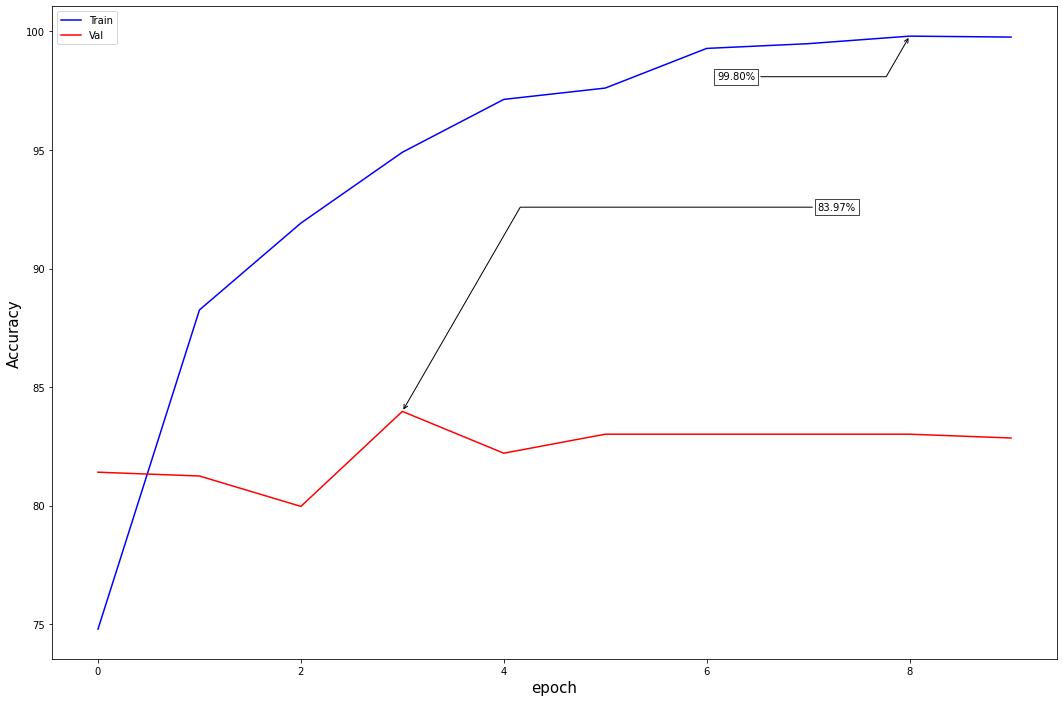

In [30]:
plot_accuracy(model_fit)

#### Analyze Result on Test Dataset:

In [33]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("./tmp/checkpoint")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
    
# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("./tmp/checkpoint")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()


11/11 [==============================] - 2s 106ms/step

Test Accuracy: 72.08%

11/11 [==============================] - 1s 105ms/step


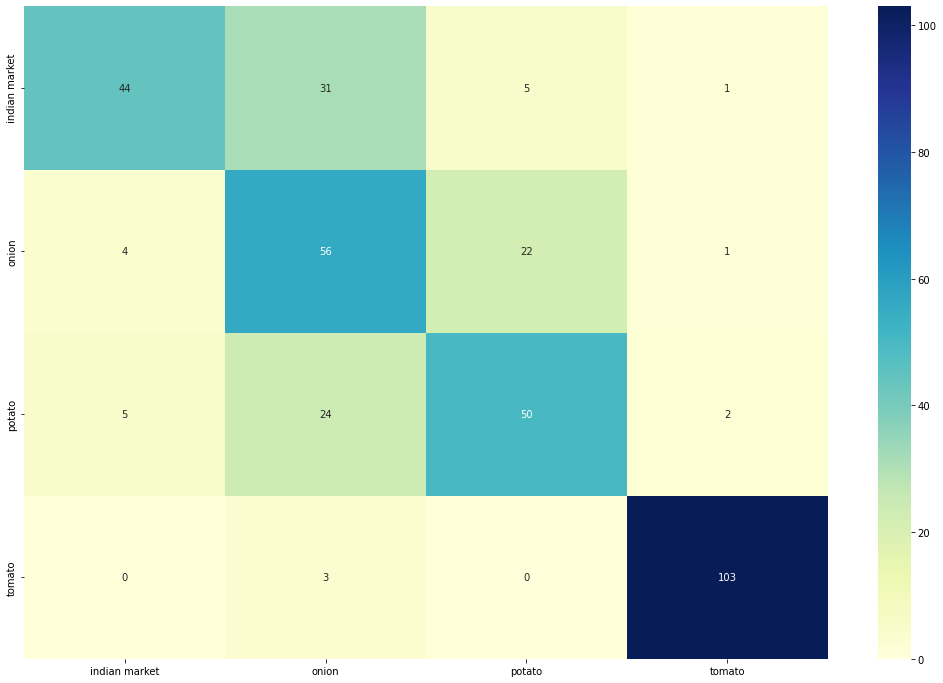

In [34]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

### Improving Baseline CNN to reduce Overfitting:

In [35]:
def new_arch(height=224, width=224):
    num_classes = 4
    hidden_size = 256
    
    model = tf.keras.Sequential(
        name="new_model",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                    kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                    kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                    kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                    kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                    kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model


In [36]:
def compile_train(model, train_ds, val_ds, epochs=10, ckpt_path="./tmp/checkpoint"):
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001
        ),
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        ),
        tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
    ]
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [37]:
def preprocess_v2(train_data, val_data, test_data, target_height=224, target_width=224):
    # Data Processing Stage with resizing and rescaling operations #same as before for test,val
    data_preprocess = tf.keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )
    # Data Processing Stage with resizing and rescaling operations
    data_augmentation = tf.keras.Sequential(
        name="data_augmentation",
        layers=[
            layers.Resizing(256, 256), # First resize to 256,256
            layers.RandomCrop(target_height, target_width), # Then randomly crop 224,224 region
            layers.Rescaling(1.0/255), # Finally rescale
        ]
    )
    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(
        lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds = val_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    test_ds = test_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = preprocess_v2(train_data, val_data, test_data)

In [39]:
model = new_arch()
model_fit = compile_train(model, train_ds, val_ds, epochs=100)

Epoch 1/100
79/79 [==============================] - 97s 1s/step - loss: 1.3987 - accuracy: 0.7264 - val_loss: 1.9975 - val_accuracy: 0.3638 - lr: 0.0010
Epoch 2/100
79/79 [==============================] - 87s 1s/step - loss: 1.1510 - accuracy: 0.7985 - val_loss: 1.8551 - val_accuracy: 0.4151 - lr: 0.0010
Epoch 3/100
79/79 [==============================] - 87s 1s/step - loss: 1.0921 - accuracy: 0.8096 - val_loss: 2.3947 - val_accuracy: 0.3237 - lr: 0.0010
Epoch 4/100
79/79 [==============================] - 89s 1s/step - loss: 0.9930 - accuracy: 0.8200 - val_loss: 1.8593 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 5/100
79/79 [==============================] - 95s 1s/step - loss: 0.8757 - accuracy: 0.8479 - val_loss: 1.5402 - val_accuracy: 0.5978 - lr: 0.0010
Epoch 6/100
79/79 [==============================] - 97s 1s/step - loss: 0.8849 - accuracy: 0.8391 - val_loss: 1.7156 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 7/100
79/79 [==============================] - 108s 1s/step - loss: 0.

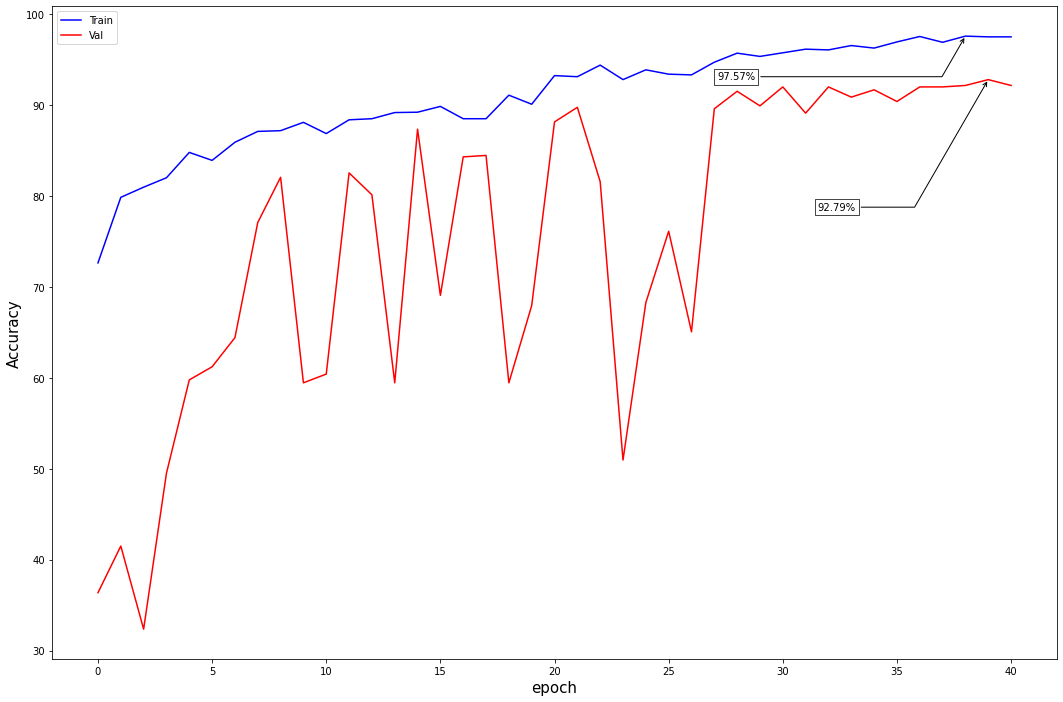

In [40]:
plot_accuracy(model_fit)

11/11 [==============================] - 3s 210ms/step

Test Accuracy: 92.31%

11/11 [==============================] - 3s 203ms/step


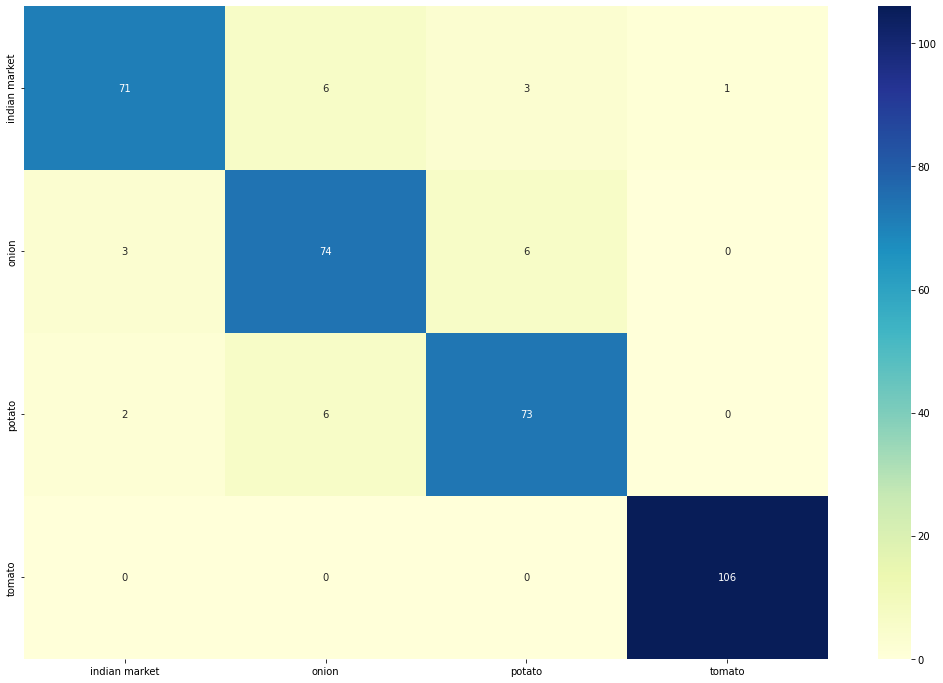

In [41]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

### Finetuning Pretrained model (MobliNetV3Large):

In [42]:
def preprocess_mobileNet(train_data, val_data, test_data, target_height=224, target_width=224):
    # Data Processing Stage with resizing and rescaling operations #same as before for test,val
    data_preprocess = tf.keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width)
        ]
    )
    
    # Data Processing Stage with resizing and rescaling operations
    data_augmentation = tf.keras.Sequential(
        name="data_augmentation",
        layers=[
            layers.Resizing(256, 256), # First resize to 256,256
            layers.RandomCrop(target_height, target_width), # Then randomly crop 224,224 region
        ]
    )
    
    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(
        lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds = val_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    test_ds = test_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [43]:
def get_mobileNet_model(target_height=224, target_width=224, num_classes=4):
    pretrained_model = MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=(target_height, target_width, 3)
    )
    pretrained_model.trainable=False
    resnet_model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return resnet_model

In [44]:
def compile_mobileNet(model, train_ds, val_ds, epochs=10, ckpt_path="./tmp/checkpoint"):
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001
        ),
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        ),
        tf.keras.callbacks.TensorBoard(log_dir='./MobileNetGraph', histogram_freq=0, write_graph=True, write_images=True)
    ]
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    
    return model_fit


In [45]:
train_ds, val_ds, test_ds = preprocess_mobileNet(train_data, val_data, test_data)

In [46]:
model = get_mobileNet_model()
model.summary()

12683000/12683000 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 47040)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                3010624   
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,007,236
Trainable params: 3,010,884
Non-trainable params: 2,996,352
_________________________________________________________________


In [47]:
model_fit = compile_mobileNet(model, train_ds, val_ds, epochs=10)

Epoch 1/10
79/79 [==============================] - 70s 835ms/step - loss: 0.4043 - accuracy: 0.9279 - val_loss: 0.1843 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 2/10
79/79 [==============================] - 69s 866ms/step - loss: 0.0448 - accuracy: 0.9892 - val_loss: 0.1309 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 3/10
79/79 [==============================] - 66s 832ms/step - loss: 0.0155 - accuracy: 0.9944 - val_loss: 0.1913 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 4/10
79/79 [==============================] - 67s 842ms/step - loss: 0.0078 - accuracy: 0.9964 - val_loss: 0.1384 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 5/10
79/79 [==============================] - 68s 850ms/step - loss: 0.0102 - accuracy: 0.9984 - val_loss: 0.1468 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 6/10
79/79 [==============================] - 66s 833ms/step - loss: 0.0187 - accuracy: 0.9968 - val_loss: 0.1780 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 7/10
79/79 [==============================] - 67s 845ms/st

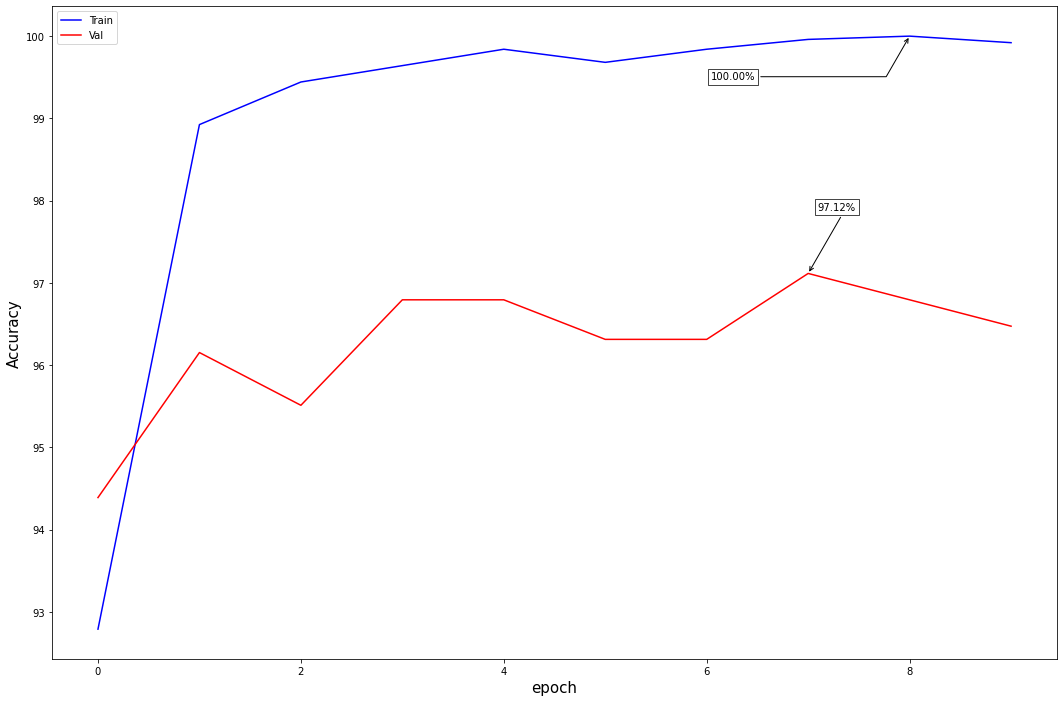

In [48]:
plot_accuracy(model_fit)

#### Model finetuned on MobileNet is the best model we've got so far with a validation accuracy close to 97.12%

### Testing Best Model:

11/11 [==============================] - 7s 566ms/step

Test Accuracy: 89.74%

11/11 [==============================] - 7s 619ms/step


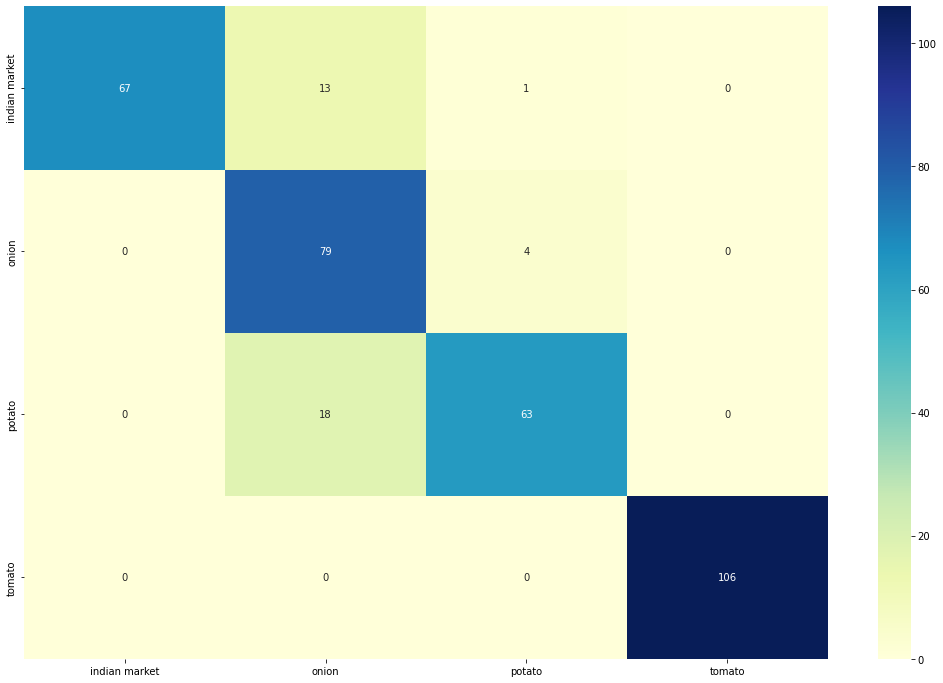

In [49]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

#### Testing accuracy is also close to 90%

In [50]:
def plot_image(pred_array, true_categories, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img/255.0)
    
    predicted_label = np.argmax(pred_array)
    true_label = np.argmax(true_categories)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ".format(
        class_names[predicted_label],
        100*np.max(pred_array)
        ),
        color=color
    )

11/11 [==============================] - 6s 535ms/step


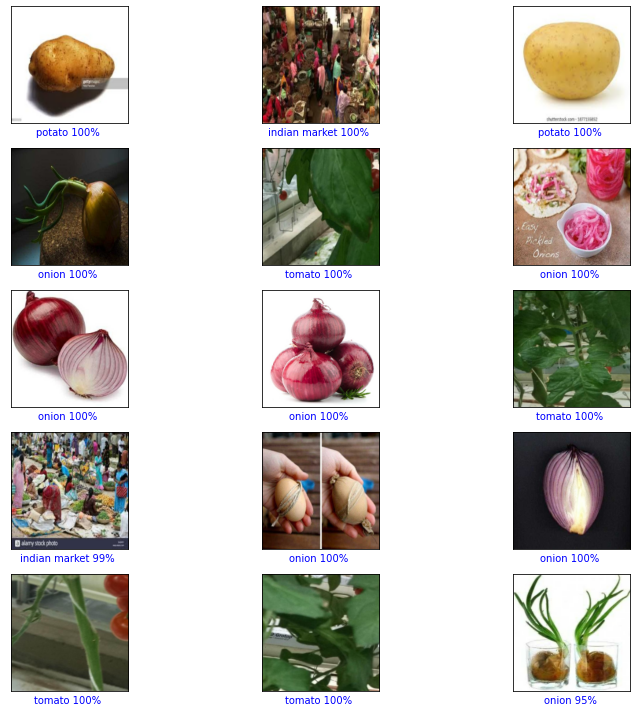

In [53]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(4*num_cols, 2*num_rows))
for i,index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(y_pred[index], true_categories[index], images[index])

plt.tight_layout()
plt.show()


## Conclusion and Insights:

1. The model fine-tuned on the pre-trained MobileNetV3Large emerged as the most successful, achieving a near 90% test accuracy.
2. This success was largely due to the similarity between our training dataset of Indian vegetables and the "Imagenet" dataset, enabling efficient fine-tuning within 10 epochs.
3. However, the model encountered difficulty differentiating between some classes, particularly confusing potatoes for onions. This represents a primary area for improvement.
4. In short, the MobileNetV3Large model demonstrated promising results, with future work aimed at addressing classification issues and further enhancing performance.
